In [39]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
np.random.seed(24)

In [3]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

In [4]:
def make_class(sep):
    """Will create classes with different degrees of separateness."""

    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_redundant=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               # The proportions of samples assigned to each class
                               weights=[0.99],
                               # How seperate the classes are
                               class_sep=sep,  
                               random_state=24,
                               )
    X = pd.DataFrame(X, columns=["varA", "varB"])

    y = pd.Series(y)

    return X, y

Over-Sampling is the process of increasing the number of samples from the minority class (as oppose to under-sampling, which is the process of decreasing the number of samples from the majority class) until we reach a desired balancing (X(minority)/X(Majority) ratio.

We can use sample extraction, at random, from the minority class, which means that the new observations created will be identical ot the existing ones, or generate new samples from the minority class.

With SMOTE/SMOTENC, all the samples are templates whereas with ADASYN and other SMOTE variant, samples closer to the boundary with the other class matter most.

# Random Over-Sampling

Random Over-Sampling is a naive technique that extracts information at random from the minority class until a certain balacing ratio is reached.

It will duplicate samples from the minority class hence increase the chances of overfitting.

In [54]:
from imblearn.over_sampling import RandomOverSampler

In [55]:
X, y = make_class(sep=2)

rov = RandomOverSampler(sampling_strategy='auto', #Balacing ratio of 1
                         random_state=24
                         )

X_resampled,y_resampled = rov.fit_resample(X,y)

In [56]:
X.shape,y.shape

((1000, 2), (1000,))

In [57]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1    987
 dtype: int64)

In [58]:
X_resampled.shape,y_resampled.shape

((1974, 2), (1974,))

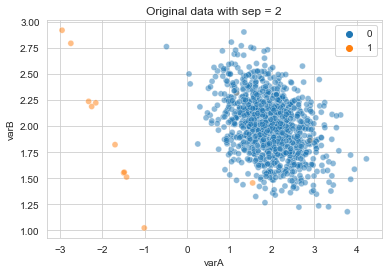

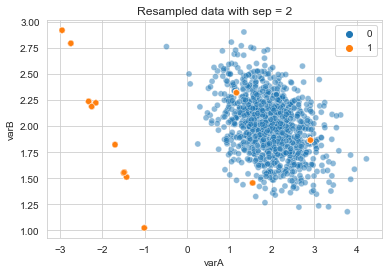

In [59]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y,alpha=0.5)

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled,alpha=0.5)

plt.title(f"Resampled data with sep = 2")
plt.show()

The new samples created from the minority class are exactly the same hence why the number of dots seems to be the same, they are just overlapping the existing one.

In [11]:
df = load_data()

In [12]:
X_resampled,y_resampled = rov.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [13]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
0    144455
1    144455
Name: target, dtype: int64


In [14]:
X_resampled.shape,y_resampled.shape,df.shape

((288910, 74), (288910,), (145751, 75))

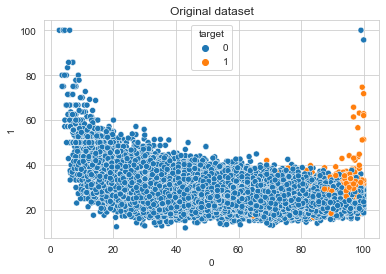

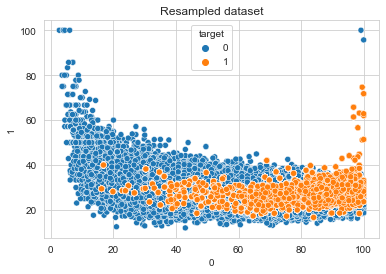

In [15]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [16]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [18]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9761414267359368
ROC-AUC for the test set: 0.9640441514681941


In [19]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [20]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9909012847587529
ROC-AUC for the test set: 0.9906494812691237


Increase in performance!

# SMOTE

SMOTE stands for Synthetic Minority Over-Sampling Technique.

It creates new samples from the minority class by interpolation, which is a type of estimation, where the new points are created within the range of the known data points.

This technique at the difference of the random over-sampling technique, will create synthetic new data points and will not sample existing ones and, therefore, will prevent having duplicated data points.

It works only with minority class data points and will find the k nearest neighbours, typically 5, then determines the distance between the neighbours and the sample we want to generate from and will create new samples within this distance (new_sample = original_sample - factor * (orginial_sample - neighbour) where the original_sample, the factor and the neighbour are choosen at random).


In [60]:
from imblearn.over_sampling import SMOTE

In [22]:
X, y = make_class(sep=2)

smote = SMOTE(sampling_strategy='auto',
            random_state=24,
            k_neighbors=5,
            n_jobs=-1,
            )
X_resampled, y_resampled = smote.fit_resample(X, y)

In [23]:
X.shape,y.shape

((1000, 2), (1000,))

In [24]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1    987
 dtype: int64)

In [25]:
X_resampled.shape,y_resampled.shape

((1974, 2), (1974,))

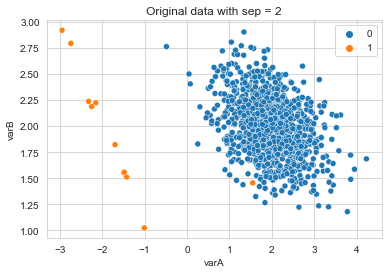

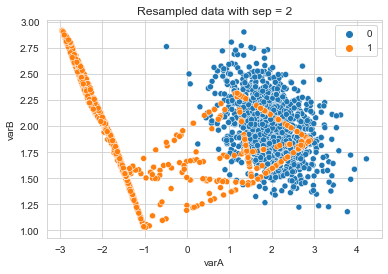

In [26]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

In [27]:
df = load_data()

In [28]:
X_resampled,y_resampled = smote.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [29]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
0    144455
1    144455
Name: target, dtype: int64


In [30]:
X_resampled.shape,y_resampled.shape,df.shape

((288910, 74), (288910,), (145751, 75))

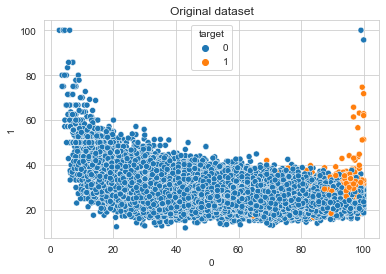

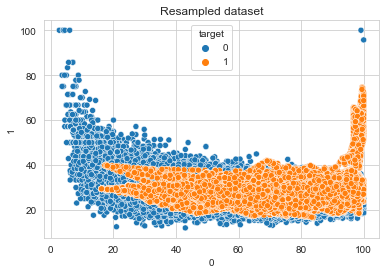

In [31]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [32]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [34]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9715863027189285
ROC-AUC for the test set: 0.9537244172832227


In [35]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [36]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9920815510276642
ROC-AUC for the test set: 0.991890383708328


Huge increase in performance!

# SMOTENC

Random Over-Sampling can work with categorical data but SMOTE and its variant and ADASYN can't. Therefore, SMOTENC was created to solve this issue, and work with every kind of variable.

It works the same as the SMOTE but will use the std of the numerical variables to remplace the categorical variables to create the new samples (new_sample = original_sample - factor * (original_sample - neighbour) for the numerical values, and the categorical values are given by the majority of the neighbours).

In [37]:
from imblearn.over_sampling import SMOTENC

In [95]:
X, y = make_class(sep=2)

In [96]:
rng = np.random.RandomState(24)
X["varC"] = rng.choice(["A","B","C"],size = len(X)).astype(object)
X["varD"] = rng.choice(["U","I","O"],size = len(X)).astype(object)

In [97]:
smotenc = SMOTENC(categorical_features = [2,3],
                  sampling_strategy='auto',
                  random_state=24,
                  k_neighbors=5,
                  n_jobs=-1,
                  )
X_resampled, y_resampled = smotenc.fit_resample(X, y)

In [98]:
X.shape,y.shape

((1000, 4), (1000,))

In [99]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1    987
 dtype: int64)

In [100]:
X_resampled.shape,y_resampled.shape

((1974, 4), (1974,))

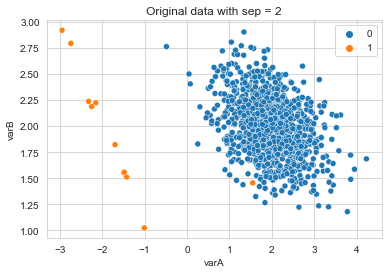

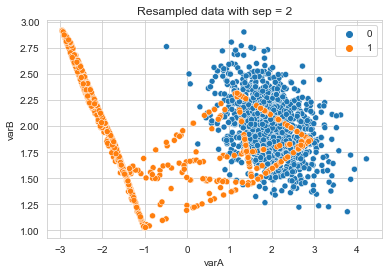

In [101]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

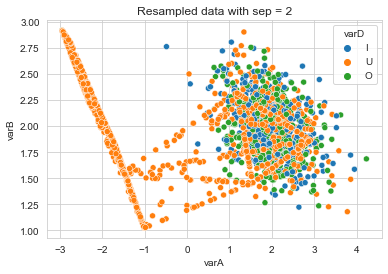

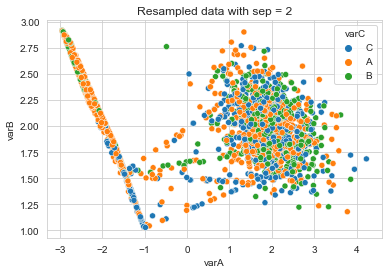

In [103]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue="varD")

plt.title(f"Resampled data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue="varC")

plt.title(f"Resampled data with sep = 2")
plt.show()

In [104]:
df = load_data()

In [105]:
X_resampled,y_resampled = smotenc.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [106]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
0    144455
1    144455
Name: target, dtype: int64


In [107]:
X_resampled.shape,y_resampled.shape,df.shape

((288910, 74), (288910,), (145751, 75))

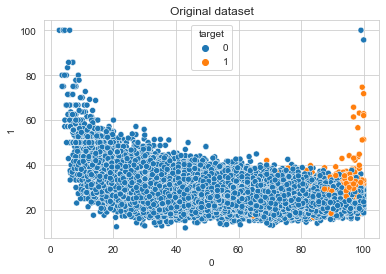

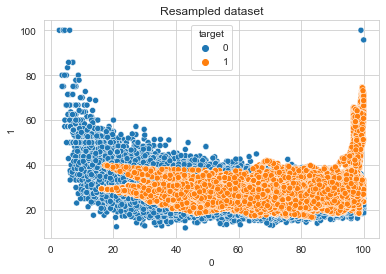

In [108]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [109]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [111]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9733298169236151
ROC-AUC for the test set: 0.95889515910924


In [112]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [113]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9932690677311584
ROC-AUC for the test set: 0.9931365960115575


Of course here the SMOTENC in this dataset is not useful because it contains only numerical variables...

# ADASYN

ADASYN uses a weighted distribution of the minority class according to how difficult are the observations to be classified or learned, and more synthetic data will be sampled from the harder observations to classify (whereas SMOTE uses all the samples from the minority class).

It uses all the sample of the KNN where the SMOTE uses only the one from the minority class and it interpoles from samples from the minority class and their neighbours, as opposed to the SMOTE which interpoles only from the minority class.

It works as follow:
* Determine the balancing ratio (BR = X(Minority) / X(Majority)).
* Determine the number of samples to be generated.
* Train a KNN using the entire dataset.
* Find the k closest neighbours for each observation from the minority class.
* Determine the weighting r (r = D neighbours from the majority class / k neighours).
* Normalise r (r(norm) = r / sum(rs)).
* Calculate the number of synthetic examples that need to be generated for each observation of the minority class. (gi (nb of observations from sample i to be generated) = ri (weight from sample i) * G (nb of samples to be generated). 
* For each minority class example xi, generate gi synthetic samples (new_sample = original_sample - factor * (original_sample - neighbour (from all classes)).

In [114]:
from imblearn.over_sampling import ADASYN

In [115]:
X, y = make_class(sep=2)

adasyn = ADASYN(sampling_strategy='auto',
                random_state=24,
                n_neighbors=5,
                n_jobs=-1,
                )
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [116]:
X.shape,y.shape

((1000, 2), (1000,))

In [117]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1    986
 dtype: int64)

In [118]:
X_resampled.shape,y_resampled.shape

((1973, 2), (1973,))

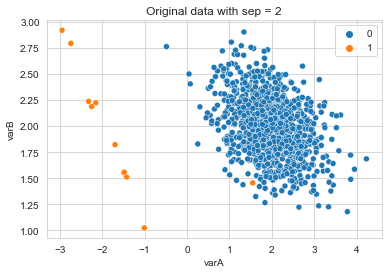

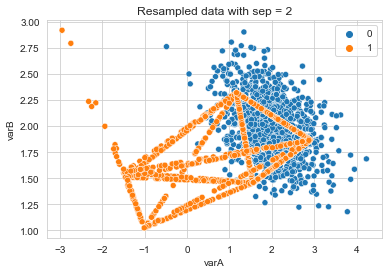

In [119]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

Creates new synthetic data using the neighbours from both the minority and majority class.

In [121]:
df = load_data()

In [122]:
X_resampled,y_resampled = adasyn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [123]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
1    144578
0    144455
Name: target, dtype: int64


In [124]:
X_resampled.shape,y_resampled.shape,df.shape

((289033, 74), (289033,), (145751, 75))

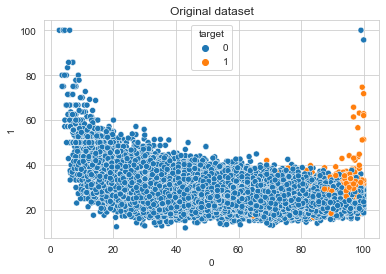

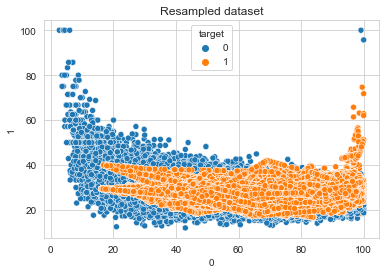

In [125]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [126]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [127]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [128]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9757822764655409
ROC-AUC for the test set: 0.9631926185362223


In [129]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [130]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9887849662325372
ROC-AUC for the test set: 0.988727336105278


Increase in performance!

# Bordeline SMOTE

It is a variation of SMOTE which creates new synthetic data from samples of the minority classes that are at the boundary of the majority class (or classes).

It has two variation, bordeline-1 and bordeline-2.

It works as following:
* Trains a KNN within the whole dataset.
* Finds and ignores observations from the minority class which K neighbours belong to the majority class (they are considered as noise and hence irrelevant).
* Finds and ignore observation from the minority class which K neighbours belong to the minority class (they are easy to classify hence safe).
* Select the observations from the minority class if most of their neighbours are from the majority class (danger group).
* Variant 1:
    * Fits KNN belonging to the minority class (all minority example).
    * Interpolates synthetic samples like SMOTE (new_sample = original_sample - factor * (original_sample - neighbour ) from the observations in the danger group and its neighbours from the minority class (danger group or not).
* Variant 2:
    * Fits KNN belonging to the minority class (all minority example).
    * Interpolates synthetic samples like SMOTE (new_sample = original_sample - factor * (original_sample - neighbour) from the observations in the danger group and its neighbours from the minority class (danger group or not).
    * AND Interpolates synthetic samples like SMOTE (new_sample = original_sample - factor * (original_sample - neighbour) from the observations in the danger group and its neighbours from the majority class but closer to the danger class, where factor can take a value between [0,0.5] to ensure the proximity of the newly created synthetic samples to the minority class observations.

In [131]:
from imblearn.over_sampling import BorderlineSMOTE

In [132]:
X, y = make_class(sep=2)

bsmote = BorderlineSMOTE(sampling_strategy='auto',
                         random_state=24,
                         k_neighbors=5,
                         n_jobs=-1,
                         m_neighbors=10,
                         kind='borderline-1',
                         )
X_resampled, y_resampled = bsmote.fit_resample(X, y)

In [133]:
X.shape,y.shape

((1000, 2), (1000,))

In [134]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1     13
 dtype: int64)

In [135]:
X_resampled.shape,y_resampled.shape

((1000, 2), (1000,))

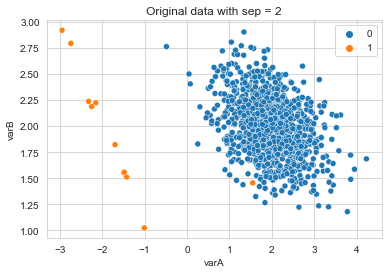

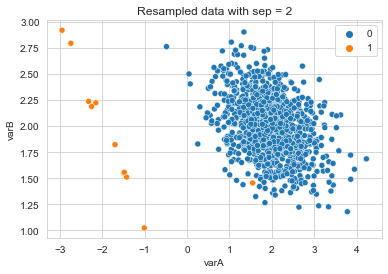

In [136]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

Classes are too seperated to make this technique work in this particular case.

In [137]:
df = load_data()

In [138]:
X_resampled,y_resampled = adasyn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [139]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
1    144578
0    144455
Name: target, dtype: int64


In [140]:
X_resampled.shape,y_resampled.shape,df.shape

((289033, 74), (289033,), (145751, 75))

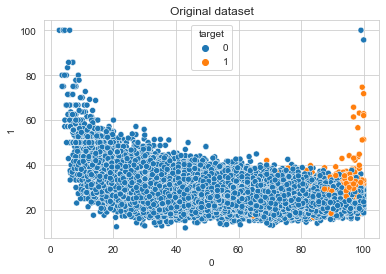

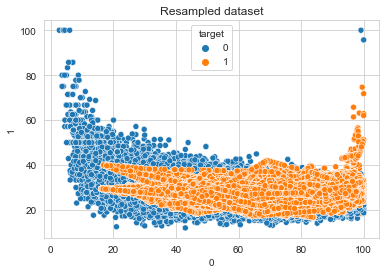

In [141]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [142]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [143]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [144]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.976241706506009
ROC-AUC for the test set: 0.962323265557589


In [145]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [146]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9892016295459223
ROC-AUC for the test set: 0.9891668673285223


Increase in performance!

# SVM SMOTE

SVM SMOTE is an extend of SMOTE which creates synthetic data only from the minority points that are closer to the boundary given by the boudary Support vectors from a SVM of the majority class.

New instances are created between the support vectors from the minority class and its neighbours by interpolation or extrapolation:
* If most neighbours are from the majority class -> Interpolation, the boudary is too crowded with the majority.
* If most neighbours are from the minority class -> Extrapolation, to expand the boundary.

It works as follow:
* First, find the support vectors from the minority class.
* Find m neighbours.
* If most neighbours are from the minority class:
    * Extrapolation.
    * KNN minority data only for synthetic data.
* If most neighbours are from the majority class:
    * Interpolation.
    * KNN minority data only for synthetic data.
    
Extrapolation: New_sample = support_vector - factor * (support_vector - neighbour) where neighbour is not choosen at random but it selects the closest to furthest neighbour in order.
Interpolation: New_sample = support_vector + factor * (neighbour - support_vector) where neighbour is not choosen at random but it selects the closest to furthest neighbour in order.

In [210]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.svm import SVC

In [211]:
X, y = make_class(sep=2)

svmsmote = SVMSMOTE(sampling_strategy='auto',
                    random_state=24,
                    k_neighbors=5,
                    n_jobs=-1,
                    m_neighbors=10,
                    svm_estimator=SVC(kernel="linear"),
                    out_step=0.5,
                    )
X_resampled, y_resampled = svmsmote.fit_resample(X, y)

In [212]:
clf = SVC(kernel="linear")

In [213]:
clf.fit(X,y)

SVC(kernel='linear')

In [214]:
clf.support_

array([272, 310, 434, 792, 838, 969, 115, 149, 309, 364, 472, 552, 602],
      dtype=int32)

In [215]:
len(clf.support_)

13

In [216]:
clf.support_vectors_

array([[ 0.74650181,  1.77765101],
       [ 0.89626802,  1.58179713],
       [-0.48407682,  2.76108498],
       [ 0.25465484,  1.82841641],
       [ 0.30533692,  2.18416256],
       [ 0.07620115,  2.40410004],
       [ 1.1653605 ,  2.31987252],
       [ 1.54794186,  1.45505631],
       [-2.73881028,  2.79294857],
       [-1.42495221,  1.51164266],
       [-1.69710106,  1.8220167 ],
       [ 2.91083575,  1.86527389],
       [-2.15070383,  2.22269723]])

In [217]:
X.shape,y.shape

((1000, 2), (1000,))

In [218]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1    345
 dtype: int64)

In [219]:
X_resampled.shape,y_resampled.shape

((1332, 2), (1332,))

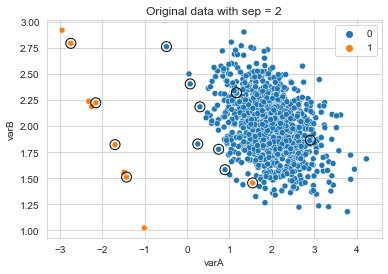

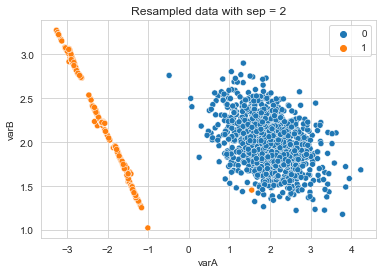

In [220]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)
plt.scatter(clf.support_vectors_[:,0],
                clf.support_vectors_[:,1],
               s=100,
               linewidth=1,
               facecolors="none",
               edgecolors="k")

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

In [221]:
df = load_data()

In [222]:
X_resampled,y_resampled = adasyn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [223]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
1    144578
0    144455
Name: target, dtype: int64


In [224]:
X_resampled.shape,y_resampled.shape,df.shape

((289033, 74), (289033,), (145751, 75))

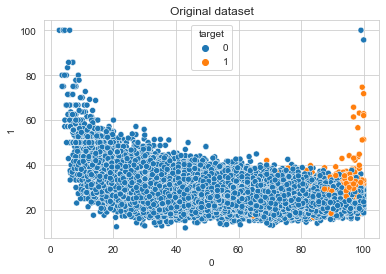

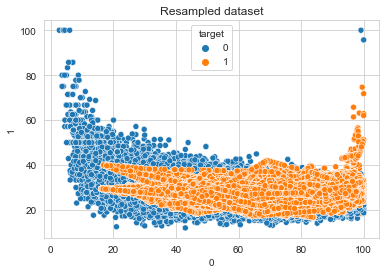

In [225]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [226]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [227]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [228]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9752713456760438
ROC-AUC for the test set: 0.964505044950317


In [229]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [230]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9884360097789372
ROC-AUC for the test set: 0.9883534383619854


Improvement!

# K-Means SMOTE

It oversamples from clusters with enough samples from the minority class, and it allows to avoid sampling noise. The idea is to contemplate intra-class cluster when creating new synthetic examples.

It works as follow:
* First of all, find the k number of clusters within the dataset (need to have an idea of how many clusters the dataset contains).
* Secondly, select clusters where % Minority class > Threshold.
* Then, weight the clusters (with Euclidean Distances (L2)) -> Determine how many samples are going to be created for each cluster.
    * L2 mean = Mean Euclidean distance between minority samples.
    * density = X(min) / L2Mean^(nb of features).
    * Sparcity = 1 / density.
    * Cluster Sparticy = Sparcity / sum(Sparcity of all clusters).
* Calculate the number of synthetic examples that need to be generated for each cluster (gi number of examples to be be generated from the cluster i = csi(cluster sparicity) * G (total number of examples to be be generated)).
* and then use the interpolation to calculate the place of the new observations (new_sample = original_sample - factor * (original_sample - neighbour)).

In [247]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import KMeans

In [254]:
X, y = make_class(sep=2)

svmsmote = KMeansSMOTE(sampling_strategy='auto',
                       random_state=24,
                       k_neighbors=2,
                       n_jobs=-1,
                       kmeans_estimator=None,
                       cluster_balance_threshold='auto',
                       density_exponent='auto',
                       )
X_resampled, y_resampled = svmsmote.fit_resample(X, y)

In [255]:
X.shape, y.shape

((1000, 2), (1000,))

In [256]:
y.value_counts(), y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 1    988
 0    987
 dtype: int64)

In [257]:
X_resampled.shape, y_resampled.shape

((1975, 2), (1975,))

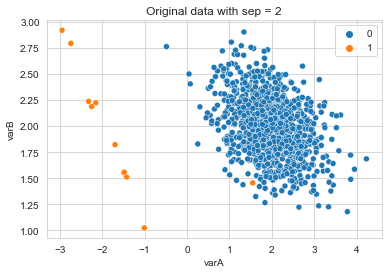

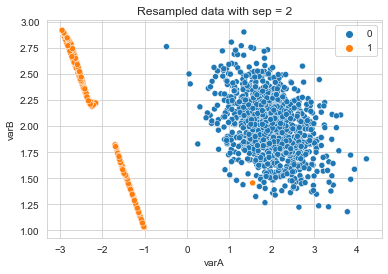

In [258]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original data with sep = 2")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

In [259]:
df = load_data()

In [260]:
X_resampled,y_resampled = adasyn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [261]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
1    144578
0    144455
Name: target, dtype: int64


In [262]:
X_resampled.shape,y_resampled.shape,df.shape

((289033, 74), (289033,), (145751, 75))

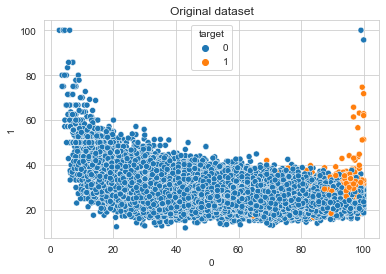

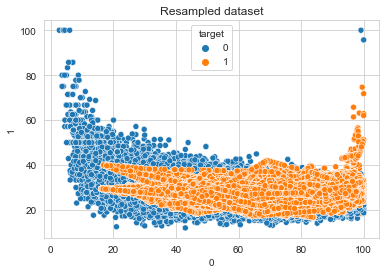

In [263]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [264]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [265]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [266]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9766403336145708
ROC-AUC for the test set: 0.9676626971511602


In [267]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [268]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.988899405779812
ROC-AUC for the test set: 0.9888234207200249


Better improvement!

# Performance comparaison between different over-sampling techniques

In [ ]:
# Importing the needed libraries
from collections import Counter

from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets